##Data Ingestion

In [0]:
# Install necessary libraries
import requests
import datetime

In [0]:
# API setup
API_KEY = 'c1d0f294ee92ad3c62e99d697f6f615a' 
CITY = 'West Bengal'
URL = f"http://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}"

##Data Validation and Error Handling

In [0]:
# Function to fetch weather data
def fetch_weather_data():
    response = requests.get(URL)
    if response.status_code == 200:
        data = response.json()
        return {
            'city': data['name'],
            'temperature': data['main']['temp'],
            'description': data['weather'][0]['description'],
            'timestamp': datetime.datetime.now().isoformat()
        }
    else:
        print(f"Error: {response.status_code}")
        return None

In [0]:
# Fetch and display weather data
weather_data = fetch_weather_data()
print(weather_data)

{'city': 'West Bengal', 'temperature': 304.56, 'description': 'clear sky', 'timestamp': '2024-11-03T09:22:45.374898'}


##Data Storage

In [0]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.getOrCreate()

# Convert weather data to DataFrame
weather_df = spark.createDataFrame([weather_data])

# Save the DataFrame to Delta Lake
weather_df.write.format("delta").mode("append").save("/mntt/delta/weather_data")

##Data Preprocessing and Cleaning 

In [0]:
weather_df = spark.read.format("delta").load("/mntt/delta/weather_data")

# Clean data: drop null values
cleaned_df = weather_df.dropna()

# Show cleaned data
cleaned_df.show()

+-----------+----------------+-----------+--------------------+
|       city|     description|temperature|           timestamp|
+-----------+----------------+-----------+--------------------+
|  Bengaluru|scattered clouds|     295.88|2024-11-01T18:16:...|
| Tamil Nadu| overcast clouds|     301.85|2024-11-03T09:04:...|
|    Kitturu| overcast clouds|     297.32|2024-11-01T18:15:...|
|West Bengal|       clear sky|     304.56|2024-11-03T09:17:...|
|West Bengal|       clear sky|     304.56|2024-11-03T09:16:...|
|      Kochi| overcast clouds|     299.14|2024-11-01T18:19:...|
|West Bengal|       clear sky|     304.56|2024-11-03T09:13:...|
|West Bengal|       clear sky|     304.56|2024-11-03T09:22:...|
|West Bengal|       clear sky|     304.56|2024-11-03T09:15:...|
|     Kerala|   broken clouds|     303.97|2024-11-03T09:07:...|
|  Jharkhand|       clear sky|     302.15|2024-11-03T08:24:...|
|  Rajasthan|       clear sky|      306.6|2024-11-03T08:31:...|
|       Pune|   broken clouds|     297.6

##Data Analysis and Aggregation in Scala

In [0]:
%scala
import org.apache.spark.sql.SparkSession
import org.apache.spark.sql.functions._
val weatherDataPath = "/mntt/delta/weather_data" 
val rawData = spark.read.format("delta").load(weatherDataPath)
rawData.show()
val cleanedData = rawData
  .select(
    col("city"),
    col("temperature").cast("double"), 
    col("description"),
    col("timestamp").cast("timestamp")
  )
  .na.drop()  // Drop rows with any missing values

// Calculate the average temperature per city
val averageTemp = cleanedData.groupBy("city").agg(avg("temperature").alias("avg_temperature"))

// Display the result
averageTemp.show()


+-----------+----------------+-----------+--------------------+
 city| description|temperature| timestamp|
+-----------+----------------+-----------+--------------------+
 Bengaluru|scattered clouds| 295.88|2024-11-01T18:16:...|
 Tamil Nadu| overcast clouds| 301.85|2024-11-03T09:04:...|
West Bengal| clear sky| 304.56|2024-11-03T09:13:...|
 Kochi| overcast clouds| 299.14|2024-11-01T18:19:...|
 Kerala| broken clouds| 303.97|2024-11-03T09:07:...|
 Jharkhand| clear sky| 302.15|2024-11-03T08:24:...|
 Pune| broken clouds| 297.68|2024-11-01T18:20:...|
 Kanpur| clear sky| 297.05|2024-11-01T18:21:...|
 Rajkot| clear sky| 306.66|2024-11-03T06:35:...|
 Punjab| clear sky| 307.94|2024-11-03T07:34:...|
 Trivandrum| mist| 298.14|2024-11-02T16:11:...|
 Trivandrum| mist| 298.14|2024-11-02T17:17:...|
 Trivandrum| mist| 300.14|2024-11-01T18:24:...|
 Trivandrum| mist| 298.14|2024-11-02T17:16:...|
 Hyderabad| haze| 297.88|2024-11-01T18:18:...|
 Agra| clear sky| 299.01|2024-11-01T18:20:...|
 Chennai| mist| 301.51|2024-11-01T18:17:...|
 Lucknow| mist| 294.14|2024-11-01T18:17:...|
 Jaipur| haze| 297.77|2024-11-01T18:18:...|
 Mumbai| haze| 303.14|2024-11-01T18:17:...|
+-----------+----------------+-----------+--------------------+
only showing top 20 rows

+-----------+------------------+
 city| avg_temperature|
+-----------+------------------+
 Tamil Nadu| 301.85|
 Bengaluru| 295.88|
 Kitturu| 297.32|
West Bengal|304.56000000000006|
 Kochi| 299.14|
 Kerala| 303.97|
 Haryana| 306.4|
 Jharkhand| 302.15|
 Gujarat| 305.61|
 Pune| 297.68|
 Rajasthan| 306.6|
 Punjab| 307.94|
 Ahmedabad| 299.17|
 Trivandrum| 298.64|
 Kanpur| 297.05|
 Rajkot| 306.66|
 Assam| 301.5|
 Hyderabad| 297.88|
 Chennai| 301.51|
 Lucknow| 294.14|
+-----------+------------------+
only showing top 20 rows

import org.apache.spark.sql.SparkSession
import org.apache.spark.sql.functions._
weatherDataPath: String = /mntt/delta/weather_data
rawData: org.apache.spark.sql.DataFrame = [city: string, description: string ... 2 more fields]
cleanedData: org.apache.spark.sql.DataFrame = [city: string, temperature: double ... 2 more fields]
averageTemp: org.apache.spark.sql.DataFrame = [city: string, avg_temperature: double]

##Data Visualization

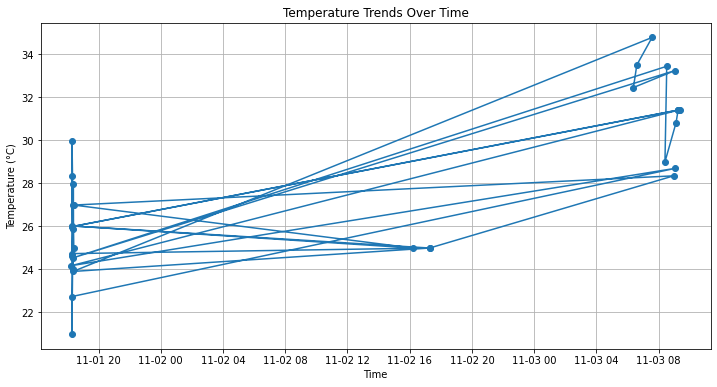

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

df = spark.read.format("delta").load("/mntt/delta/weather_data").toPandas()

# Convert temperature from Kelvin to Celsius
df['temperature_celsius'] = df['temperature'] - 273.15

# Plot temperature trends over time
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df['timestamp']), df['temperature_celsius'], marker='o', linestyle='-')
plt.title('Temperature Trends Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


##Building Report Using Dashboard

In [0]:
%scala
// Create a temporary view from your cleaned DataFrame
cleanedData.createOrReplaceTempView("weather_data")

In [0]:
cleaned_df.show()

+-----------+----------------+-----------+--------------------+
|       city|     description|temperature|           timestamp|
+-----------+----------------+-----------+--------------------+
|  Bengaluru|scattered clouds|     295.88|2024-11-01T18:16:...|
| Tamil Nadu| overcast clouds|     301.85|2024-11-03T09:04:...|
|    Kitturu| overcast clouds|     297.32|2024-11-01T18:15:...|
|West Bengal|       clear sky|     304.56|2024-11-03T09:17:...|
|West Bengal|       clear sky|     304.56|2024-11-03T09:16:...|
|      Kochi| overcast clouds|     299.14|2024-11-01T18:19:...|
|West Bengal|       clear sky|     304.56|2024-11-03T09:13:...|
|West Bengal|       clear sky|     304.56|2024-11-03T09:22:...|
|West Bengal|       clear sky|     304.56|2024-11-03T09:15:...|
|     Kerala|   broken clouds|     303.97|2024-11-03T09:07:...|
|  Jharkhand|       clear sky|     302.15|2024-11-03T08:24:...|
|  Rajasthan|       clear sky|      306.6|2024-11-03T08:31:...|
|       Pune|   broken clouds|     297.6

In [0]:
%sql
SELECT 'Weather Collection Dashboard' AS title;

title
Weather Collection Dashboard


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
SELECT COUNT(*) AS total_records FROM weather_data;

total_records
34


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
SELECT city from weather_data

city
Bengaluru
Tamil Nadu
Kitturu
West Bengal
West Bengal
Kochi
West Bengal
West Bengal
West Bengal
Kerala


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
SELECT city, AVG(temperature) AS avg_temperature
FROM weather_data
GROUP BY city
ORDER BY avg_temperature DESC


city,avg_temperature
Punjab,307.94
Rajkot,306.66
Rajasthan,306.6
Haryana,306.4
Gujarat,305.61
West Bengal,304.56000000000006
Kerala,303.97
Mumbai,303.14
Jharkhand,302.15
Tamil Nadu,301.85


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
SELECT temperature
FROM weather_data


temperature
295.88
301.85
297.32
304.56
304.56
299.14
304.56
304.56
304.56
303.97


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
SELECT city, description, temperature, timestamp
FROM weather_data
ORDER BY city, timestamp DESC;


city,description,temperature,timestamp
Agra,clear sky,299.01,2024-11-01T18:20:55.270+0000
Ahmedabad,smoke,299.17,2024-11-01T18:16:42.640+0000
Assam,clear sky,301.5,2024-11-03T08:57:52.185+0000
Bengaluru,scattered clouds,295.88,2024-11-01T18:16:23.582+0000
Chennai,mist,301.51,2024-11-01T18:17:55.142+0000
Gujarat,clear sky,305.61,2024-11-03T06:22:41.183+0000
Haryana,clear sky,306.4,2024-11-03T09:02:57.947+0000
Hyderabad,haze,297.88,2024-11-01T18:18:16.001+0000
Jaipur,haze,297.77,2024-11-01T18:18:45.137+0000
Jharkhand,clear sky,302.15,2024-11-03T08:24:19.350+0000


Databricks visualization. Run in Databricks to view.

##Monitor Data Pipeline

In [0]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [0]:
def monitor_delta_table():
    try:
        # Track the current record count in Delta table
        logging.info("Fetching Delta table record count...")
        record_count = spark.read.format("delta").load("/mntt/delta/weather_data").count()
        logging.info(f"Current record count in Delta table: {record_count}")
        
        # Track the schema of the Delta table
        logging.info("Fetching Delta table schema...")
        schema = spark.read.format("delta").load("/mntt/delta/weather_data").schema
        logging.info(f"Delta table schema: {schema}")

    except Exception as e:
        logging.error(f"Error occurred while monitoring Delta table: {str(e)}")

# Run the monitor function
monitor_delta_table()


In [0]:
def monitor_delta_table_with_alerts():
    try:
        # Track record count
        record_count = spark.read.format("delta").load("/mntt/delta/weather_data").count()
        logging.info(f"Record count: {record_count}")
        
        # Track schema
        schema = spark.read.format("delta").load("/mntt/delta/weather_data").schema
        logging.info(f"Schema: {schema}")

        if record_count < 1000:
            logging.warning("Alert: Record count is below the expected threshold.")
        
    except Exception as e:
        logging.error(f"Monitoring error: {str(e)}")

# Run monitoring with alerts
monitor_delta_table_with_alerts()


##Automate Data Collection

In [0]:
!pip install schedule

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-7b4e5e3d-0617-4968-ba95-14dd9552a773/bin/python -m pip install --upgrade pip' command.


In [0]:
import requests
import schedule
import time
import datetime
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.getOrCreate()

# Function to fetch weather data
def collect_weather_data():
    response = requests.get(URL)
    if response.status_code == 200:
        data = response.json()
        weather_data = {
            'city': data['name'],
            'temperature': data['main']['temp'],
            'description': data['weather'][0]['description'],
            'timestamp': datetime.datetime.now().isoformat(),
        }

        # Convert weather data to DataFrame
        weather_df = spark.createDataFrame([weather_data])

        # Save the DataFrame to Delta Lake
        weather_df.write.format("delta").mode("append").save("/mntt/delta/weather_data")
        print("Weather data collected and stored successfully.")

    else:
        print(f"Error: {response.status_code}")

# Schedule the job to run at regular intervals
schedule.every().hour.do(collect_weather_data) 

# Keep the scheduler running
while True:
    schedule.run_pending()
    time.sleep(1)


##Real-Time Weather Alerts

In [0]:
# Function to check weather conditions and trigger alerts
def check_weather_alerts(weather_data):
    temp_threshold = 30 
    if weather_data['temperature'] - 273.15 > temp_threshold:
        send_alert(f"High temperature alert in {weather_data['city']}! Current temperature: {weather_data['temperature'] - 273.15:.2f}°C")

# Function to send alerts
def send_alert(message):
    print("ALERT:", message)

# Check weather alerts based on current data
if weather_data:
    check_weather_alerts(weather_data)